<a href="https://colab.research.google.com/github/digichriz/EMBA2026-Lab/blob/main/exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# My awesome LLM-Application **Reputatio AI**

###Setup
First, make the necessary imports.
Note that further imports may have to be made in addition to the ones below, if your application uses additional fetures such as loaders and tools. You can find the code for these imports in the respective sections of the tutorial notebooks.

In [96]:
!pip install -q langchain langchain-community langchain-core langchain-openai langchain-huggingface langchain-google-genai
from google.colab import userdata
#from langchain.chains import SequentialChain, LLMChain
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
import os
import pprint
import getpass
from IPython.display import Markdown
import IPython.display as ipd
from PIL import Image
import urllib.request
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display
import base64
from IPython.display import Image, display
from openai import OpenAI

Then, assign the API keys to be able to use OpenAI, Google Serper, Huggingface, etc.

When working with sensitive information like API keys or passwords in Google Colab, it's crucial to handle data securely. As you learnt in the tutorial session, two common approaches for this are using **Colab's Secrets Manager**, which stores and retrieves secrets without exposing them in the notebook, and `getpass`, a Python function that securely prompts users to input secrets during runtime without showing them. Both methods help ensure your sensitive data remains protected.

In [97]:
# **********************************************************************************************
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  *
# *                                                                                            *
# *                                      R E P U T A T I O   A I                                 *
# *                                                                                            *
# *                     Multi-AI perception analysis enriched with public web data              *
# *                                                                                            *
# *                                                                                            *
# *   What this notebook does                                                                   *
# *   ----------------------------------------------------------------------------------------  *
# *   • Builds a fact sheet from publicly available online information                          *
# *   • Analyzes how different AI models perceive the same entity                               *
# *   • Create an image (diagram) out of the analysis                                           *
# *   • Separates verifiable facts from AI-generated sentiment and interpretation               *
# *                                                                                            *
# *                                                                                            *
# *   Built & maintained by                                                                     *
# *   ----------------------------------------------------------------------------------------  *
# *   Christian Schmid                                                                          *
# *                                                                                            *
# *                                                                                            *
# *                                                                                            *
# *   ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★  ★ *
# *                                                                                            *
# **********************************************************************************************



#API Key Imports
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
os.environ["OPENROUTER_API_KEY"] = userdata.get("OPENROUTER_API_KEY")


# G L O B A L  V A R S
search = GoogleSerperAPIWrapper()
results = {}
sentiment_results = {}
models = []
ratings = []
client = OpenAI()

llmOpenAI = ChatOpenAI(model="gpt-5-mini")
llmGemini = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

#Openrouter API for free access on a deepseek Model as our 3rd LLM
llmDeepSeek = ChatOpenAI(
    model="nex-agi/deepseek-v3.1-nex-n1",
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ["OPENROUTER_API_KEY"],
)

#dict for storing 1:n LLMs
llms = {
    "openai": llmOpenAI,
    "gemini": llmGemini,
    "deepseek": llmDeepSeek
}

####User Input
The user is expected to provide a company name via the chat interface. Since this is not available here, I’ve stored an example company in the variable. Feel free to modify it as needed for your evaluation for more examples

In [84]:
user_input = "Georg Fischer AG"

###Prompt Templates

In [93]:

#Template to feed the different AI models
report_prompt_template = PromptTemplate(
    input_variables=["company"],
    template = ("""Based on the company name provided: {company}, generate a concise company profile and assessment.
                Include:
                - A brief description of what the company does
                - Its primary industry and general market positioning
                - Perceived strengths and weaknesses
                - Overall reputation and maturity level

                Rules:
                - Use only widely known, high-level information
                - Do not speculate or invent facts
                - Explicitly state uncertainty where information is unclear or unavailable
                - Use a neutral, analytical tone
                - Maximum length: 150–200 words
                - Return a result, and do not dodge the task"""
               )
)

#Template for one of the AI (in my case openAI) to analyze the sentiment of the results from the AI models
sentiment_prompt_template = PromptTemplate(
    input_variables=["company_analysis_sentiment"],
    template = ("""You are analyzing the output of an AI-generated company assessment.
                Input text:
                {company_analysis_sentiment}

                Your task:
                - Determine whether the overall sentiment of the text is predominantly positive, neutral, or negative
                - Explain briefly why this sentiment classification applies, referring only to the content of the text
                - Provide a sentiment rating on a scale from 1 to 5, where:
                  1 = very negative
                  2 = mostly negative
                  3 = neutral or balanced
                  4 = mostly positive
                  5 = very positive

                Rules:
                - Do not introduce new information or external knowledge
                - Base your evaluation strictly on tone, wording, and emphasis in the provided text
                - If the sentiment is mixed, explain which aspects pull it in each direction
                - Keep the total response under 120 words
                - Use a neutral, analytical tone
                - Return a result, and do not dodge the task
                - Return your result ONLY in exactly this format (3 lines, nothing else):
                  Sentiment: <positive|neutral|negative>
                  Rating: <1|2|3|4|5>
                  Rationale: <sentence>
                - No additional text, no blank lines, no punctuation after the numbers
                - Rating must be a single integer 1–5 (not "4/5", not "3 (neutral)", not "4/5 (mostly positive)")
                - Each field MUST start on a new line

                Example output:
                  Sentiment: neutral
                  Rating: 3
                  Rationale: The text is balanced and emphasizes uncertainty more than praise or criticism."""
               )
)

#Template for Image/Diagram creation
imgdiagram_prompt_template = PromptTemplate(
    input_variables=["sentiment_results"],
    template = ("""You are given sentiment analysis results from multiple AI models.

                Input data:
                {sentiment_results}

                Your task:
                - Create a clear comparison diagram that visualizes the sentiment ratings of all models
                - Use a bar chart to compare the sentiment ratings (scale 1–5)
                - Each bar must represent one model
                - The chart must be easy to read and suitable for inclusion in a report

                Output format:
                - Return ONLY a Mermaid diagram
                - Use Mermaid xychart-beta bar chart syntax
                - Do not include explanations or additional text

                Rules:
                - Use the numeric sentiment ratings exactly as provided
                - Label axes clearly (Model / Sentiment Rating)
                - Use a neutral and professional style"""
               )
)

#Template for PDF report creation
pdfreport_prompt_template = PromptTemplate(
    input_variables=[
      "company_results",
      "sentiment_results",
      "sentiment_diagram"
      ],
    template = ("""You are creating a structured analytical report intended for export as a PDF.

                Input data:
                1) Company analysis results from multiple AI models:
                {company_results}

                2) Sentiment analysis of these results:
                {sentiment_results}

                3) Sentiment comparison diagram (Mermaid):
                {sentiment_diagram}

                Your task:
                Create a well-structured report with the following sections:

                1. Executive Summary
                  - High-level overview of the company
                  - Key themes consistently mentioned across AI models

                2. Company Analysis (AI Model Perspectives)
                  - Summarize the main observations from each model
                  - Highlight common strengths, weaknesses, and uncertainties
                  - Keep the tone neutral and analytical

                3. Sentiment Analysis
                  - Explain how each model's output was evaluated
                  - Compare sentiment classifications and ratings
                  - Briefly interpret similarities and differences

                4. Sentiment Comparison Visualization
                  - Introduce the diagram
                  - Explain what it shows and how to read it
                  - Embed the provided diagram as-is

                5. Overall Conclusion
                  - Summarize how the company is perceived across models
                  - Comment on overall sentiment balance and confidence level

                Formatting rules:
                - Use clear headings and subheadings
                - Write in professional report language
                - Avoid speculation or new information
                - Ensure the text is suitable for direct PDF export
                - Do not reference prompts or AI instructions"""
               )
)

image_pimp_prompt_template = PromptTemplate(
    input_variables = [],
    template = ("""You are a professional infographic designer.

              You are given an existing bar chart image that visualizes sentiment ratings.
              Your task is to RESTYLE the image for visual quality only.

              STRICT RULES (must be followed exactly):
              - Do NOT change bar heights, proportions, or positions
              - Do NOT change numeric values, labels, or axis scales
              - Do NOT add or remove data
              - Do NOT reinterpret the chart or redraw it differently
              - Preserve the exact structure and meaning of the original chart

              ALLOWED ENHANCEMENTS:
              - Improve color palette (professional, modern)
              - Add subtle gradients or soft shadows
              - Improve typography clarity and alignment
              - Slightly round bar edges
              - Clean, neutral background
              - Improve spacing and visual balance

              STYLE:
              - Clean corporate infographic
              - Flat design with subtle depth
              - High contrast but restrained colors
              - Suitable for an executive PDF report
              - No decorative icons or illustrations

              OUTPUT:
              - A visually enhanced version of the same chart
              - Data accuracy must be preserved exactly"""
            )
)

###Analyze Company Chain




In [71]:
#Function to invoke the different LLMs to gather info about the company
def analyze_company(llms, user_input):

    #Loop through all LLMs and store their response in a dictionary
    for name, llm in llms.items():
        prompt = report_prompt_template.format(company=user_input)
        response = llm.invoke(prompt)

        content = response.content if hasattr(response, "content") else str(response)
        results[name] = content

    return results


#Call the function and store the output in results
results = analyze_company(llms, user_input)

#Show the results in markdown (optional / just for a quick control/checkpoint)
for name, text in results.items():
    display(Markdown(f"## {name.upper()} perception"))
    display(Markdown(text))


## OPENAI perception

Georg Fischer AG is a Swiss industrial technology company, founded in 1802, that develops and supplies piping systems, cast components and machine tools. It is widely known to operate through three main divisions: GF Piping Systems, GF Casting Solutions and GF Machining Solutions.

Primary industry and market positioning: Georg Fischer sits in industrial manufacturing/engineering, serving water and gas infrastructure, automotive and industrial customers, and precision-machining markets. It is an established, diversified supplier with a global presence (specific market shares and recent growth trends are not provided here).

Perceived strengths and weaknesses:
- Strengths: long corporate history and institutional maturity; diversified product portfolio across piping, casting and machining; engineering and manufacturing capabilities; global footprint (locations and scale not detailed here).
- Weaknesses: exposure to capital-goods and automotive end-markets that can be cyclical; complexity of managing disparate divisions (degree and impact not specified here).

Overall reputation and maturity level: Georg Fischer is regarded as a mature, well-established Swiss industrial firm with a long track record. Precise current financials, market position metrics and recent strategic changes are not included.

## GEMINI perception

Based solely on the company name "Georg Fischer AG":

**Description:** The company's core business and specific activities are not discernible from its name. The "AG" (Aktiengesellschaft) suffix indicates it is a public limited company, a common legal structure in German-speaking countries (Switzerland, Germany, Austria), suggesting a formally established corporate entity. The use of a personal name, "Georg Fischer," often points to a historical founder or significant figure.

**Primary Industry and General Market Positioning:** The primary industry and market positioning (e.g., B2B, B2C, specific sector) cannot be determined from the name.

**Perceived Strengths and Weaknesses:** Without knowledge of its operations or market, specific strengths and weaknesses are unclear. However, a company bearing a founder's name and structured as an "AG" might imply a legacy, established presence, and a certain level of organizational stability. Conversely, the lack of a descriptive element in the name provides no immediate indication of its competitive advantages or areas of focus.

**Overall Reputation and Maturity Level:** The company's overall reputation is unknown. Its legal form ("AG") and the use of a founder's name strongly suggest it is a mature, established organization rather than a new venture. The name itself does not provide clues regarding its current market standing or public perception.

## DEEPSEEK perception

**Georg Fischer AG**
Georg Fischer is a Swiss industrial manufacturing company founded in 1802. It operates globally with a focus on three main divisions: GF Piping Systems (flow solutions and piping), GF Casting Solutions (lightweight castings for automotive and industrial applications), and GF Machining Solutions (precision machining and additive manufacturing equipment). The company serves sectors including automotive, aerospace, energy, construction, and semiconductors.

Market positioning is solidly mid-tier in its specialized niches, recognized for engineering quality and system integration rather than scale leadership. Strengths include long-term client relationships, technical expertise, and resilience across economic cycles. Weaknesses may include exposure to cyclical end markets and less brand recognition than industrial giants. GF maintains a stable, mature reputation with consistent execution.

###Sentiment Chain

In [78]:
#Function to analyze the sentiment of the provided results
def analyze_sentiment(results, llm):

    for model_name, company_text in results.items():
        prompt = sentiment_prompt_template.format(
            company_analysis_sentiment=company_text
        )

        response = llm.invoke(prompt)
        content = response.content if hasattr(response, "content") else str(response)

        sentiment_results[model_name] = content

    return sentiment_results

#Call the function and store the output in sentiments (only 1 LLM needed - I chose openAI)
sentiments = analyze_sentiment(results, llmOpenAI)

for model_name, sentiment_text in sentiments.items():
    display(
        Markdown(
            f"## {model_name.upper()} – Sentiment Evaluation\n\n{sentiment_text}"
        )
    )


## OPENAI – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The text emphasizes positive attributes—long history, diversified product portfolio, engineering capabilities and global footprint—while acknowledging cyclical exposure and divisional complexity, so the overall tone is mostly positive

## GEMINI – Sentiment Evaluation

Sentiment: neutral
Rating: 3
Rationale: The text is largely descriptive and uncertain, noting no criticism and only tentative positive implications (legacy, maturity) while emphasizing lack of concrete information.

## DEEPSEEK – Sentiment Evaluation

Sentiment: positive
Rating: 4
Rationale: The text is overall favorable, emphasizing strengths such as engineering quality, long-term client relationships and resilience while mentioning a few secondary weaknesses that do not dominate the assessment.

Diagram Chain

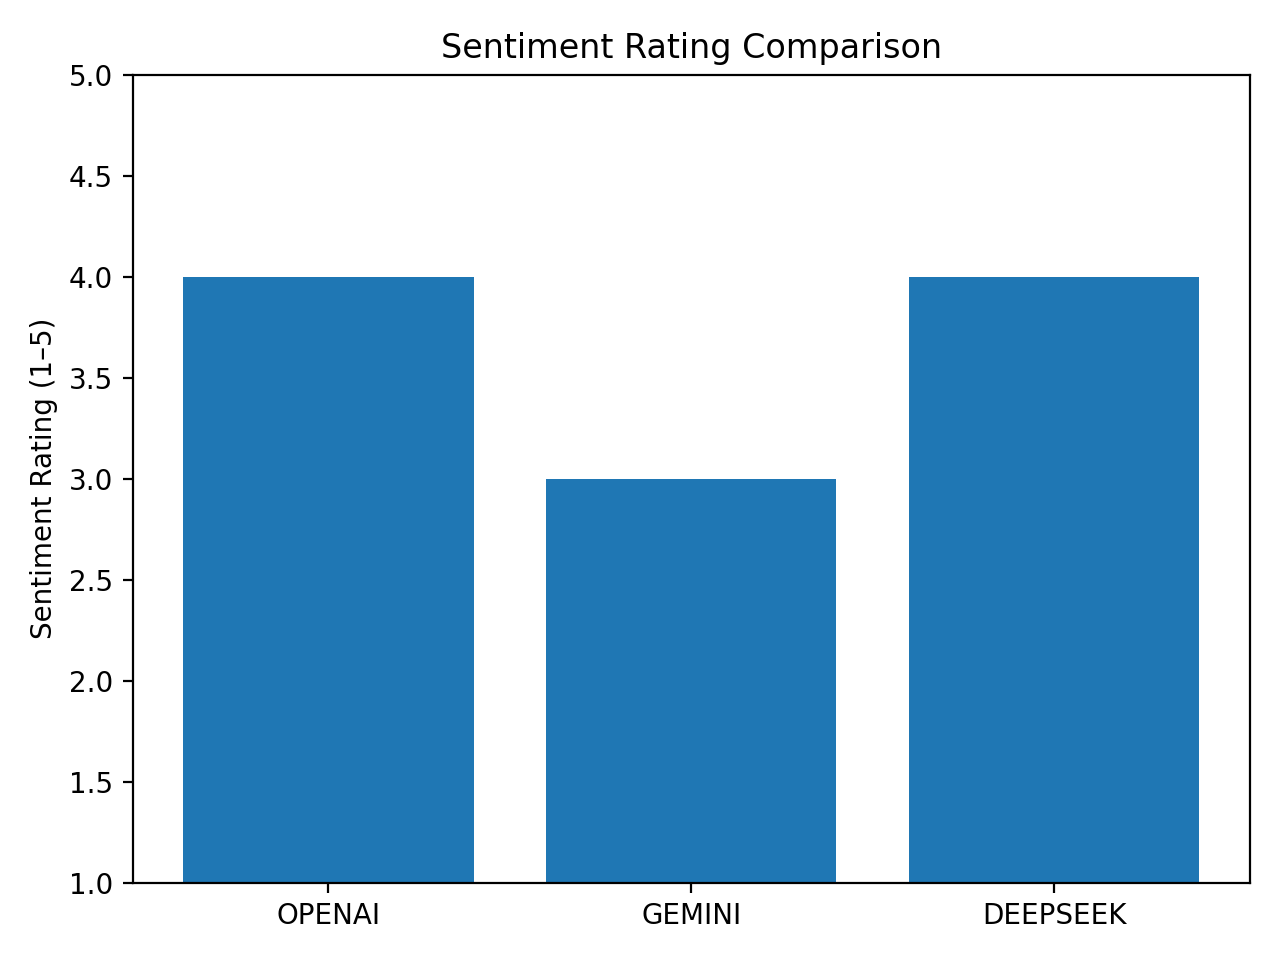

Saved: sentiment_comparison.png


In [88]:
#Function to create a PNG bar chart based on the sentiment rating with Python matplotlib library
def save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png", title="Sentiment Rating Comparison"):

    for model_name, text in sentiments.items():
        m = re.search(r"Rating:\s*([1-5])\b", str(text))
        if not m:
            raise ValueError(f"Could not find a valid 'Rating: 1-5' for model '{model_name}'. Text was:\n{text}")
        models.append(model_name.upper())
        ratings.append(int(m.group(1)))

    plt.figure()
    plt.bar(models, ratings)
    plt.ylim(1, 5)
    plt.ylabel("Sentiment Rating (1–5)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.close()

    display(Image(filename=filename))
    return filename

png_path = save_sentiment_chart_png(sentiments, filename="sentiment_comparison.png")
print("Saved:", png_path)



DiagramPimp Chain

In [104]:
import base64
from openai import OpenAI
from IPython.display import Image, display

client = OpenAI()

def pimp_sentiment_chart_image_api(
    input_png_path: str,
    output_png_path: str = "sentiment_comparison_pimped.png",
    model: str = "gpt-image-1.5",
):
    # dein Styling-Prompt aus dem PromptTemplate (statisch)
    prompt_text = image_pimp_prompt_template.format()

    # Images API: edit (nimmt ein Bild + Prompt)
    with open(input_png_path, "rb") as img_file:
        result = client.images.edit(
            model=model,
            image=img_file,
            prompt=prompt_text,
            output_format="png",
            # optional:
            # quality="high",
            # size="auto",
        )

    # GPT Image Modelle liefern base64 (b64_json)
    image_bytes = base64.b64decode(result.data[0].b64_json)
    with open(output_png_path, "wb") as f:
        f.write(image_bytes)

    display(Image(filename=output_png_path))
    return output_png_path


# Aufruf:
pimped_chart = pimp_sentiment_chart_image_api(
    input_png_path="sentiment_comparison.png",
    output_png_path="sentiment_comparison_pimped.png"
)
print("Saved:", pimped_chart)



PermissionDeniedError: Error code: 403 - {'error': {'message': 'Your organization must be verified to use the model `gpt-image-1.5`. Please go to: https://platform.openai.com/settings/organization/general and click on Verify Organization. If you just verified, it can take up to 15 minutes for access to propagate.', 'type': 'invalid_request_error', 'param': None, 'code': None}}